# Capstone Project - Metastatic Tissue Detection (Cancer Detection)

>- **Student:** Ildar Mamin
>- **Course:** INFO-6147-(01)-25F Deep Learning with PyTorch
>- **Date:** December 09, 2025
>- **Dataset:** PCAM Dataset, link: https://github.com/basveeling/pcam

## Project Description

> For my Capstone Project, I decided to build a Cancer Detection to help doctors find cancer in medical images.
For the dataset I chose the PCAM (PatchCamelyon) dataset, which contains thousands of microscope pictures of lymph node tissue.
>
> Using Python and PyTorch, I will train a deep learning model (specifically a CNN) to look at these pictures and decide if the tissue is Healthy or if it has a Tumor (cancer).
>
> The main goal is to show how AI can act as a "second opinion" for doctors, helping them work faster and make fewer mistakes. At the end of the project, I will present my results using charts and a Streamlit web app, where I can upload a picture and show the model working in real-time.

## 1. Imports & Setup

> **Overview:** Here we import necessary libraries. Code checks if GPU is available. Also we set random seed to 10 for reproducible results.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt

# Check for the GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print("Part 1 - Completed")

# Reproduction
torch.manual_seed(10)
np.random.seed(10)

Device: cpu
Part 1 - Completed


## 2. Data Loading

> **Overview:** Here I prepare data. First, define transform to resize and normalize. Then download PCAM dataset. Because it is very big, I take subset of 5000 images. I split data to train and validation sets, and create dataloaders.

In [11]:
# Data Transformation
data_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print("PCAM Dataset Downloading")

# Dataset Downloading
full_dataset = torchvision.datasets.PCAM(root='./data', split='train', download=True, transform=data_transform)

# We need to use subset as a dataset quite big, so I selected the first 5000 imgs.
total_images = 5000
subset_indices = list(range(total_images))
small_dataset = Subset(full_dataset, subset_indices)

# Splitting Data (80% - training, 20% - val)
train_len = int(0.8 * len(small_dataset))
val_len = len(small_dataset) - train_len

train_data, val_data = random_split(small_dataset, [train_len, val_len])

# Data Loaders - Creation
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print("Data loaded successfully.")
print(f"Training Images: {len(train_data)}")
print(f"Validation Images: {len(val_data)}")

print("Part 2 - Completed")

PCAM Dataset Downloading


Downloading...
From (original): https://drive.google.com/uc?id=1Ka0XfEMiwgCYPdTI-vv6eUElOBnKFKQ2
From (redirected): https://drive.usercontent.google.com/download?id=1Ka0XfEMiwgCYPdTI-vv6eUElOBnKFKQ2&confirm=t&uuid=be6cf1d7-7ca8-440d-aaf9-b539061cbfdb
To: C:\Users\ilari\PycharmProjects\JupyterNotebook\CapsoneProject\data\pcam\camelyonpatch_level_2_split_train_x.h5.gz
100%|██████████| 6.42G/6.42G [32:09<00:00, 3.33MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1269yhu3pZDP8UYFQs-NYs3FPwuK-nGSG
To: C:\Users\ilari\PycharmProjects\JupyterNotebook\CapsoneProject\data\pcam\camelyonpatch_level_2_split_train_y.h5.gz
100%|██████████| 21.4k/21.4k [00:00<00:00, 21.5MB/s]

Data loaded successfully.
Training Images: 4000
Validation Images: 1000
Part 2 - Completed


# 3. The Model

> **Overview:** Here I define model class MyCNN. It has 3 convolution layers with batch normalization and pooling. I add dropout to prevent overfitting. Output layer uses Sigmoid because we predict probability. Finally, I move model to device.

In [13]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # First layer: 3 inputs (RGB), 32 outputs
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        # Second layer: 32 inputs, 64 outputs
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Third layer: 64 inputs, 128 outputs
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.dropout = nn.Dropout(0.5) # Dropout to prevent overfitting
        self.fc2 = nn.Linear(512, 1)   # Output is 1 number (probability)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))

        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = MyCNN().to(device)

print("Model Initialized")
print("Part 3 - Completed")

Model Initialized
Part 3 - Completed


# 4. Training Loop

> **Overview:** Here I set learning rate and optimizer. I use BCELoss. Then I start training loop. In loop, I calculate loss, make optimization step and check validation accuracy.

In [15]:
# Settings
learning_rate = 0.001
epochs = 20

# Loss and Optimizer
# Binary Cross Entropy Loss (BCELoss)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to save values for the graphs
train_losses = []
val_accuracies = []

print("Starting training loop...")

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for i, (images, labels) in enumerate(train_loader): # mb fix
        images = images.to(device)
        # Need to reshape labels to match the output shape
        labels = labels.float().unsqueeze(1).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # optimization

        total_loss += loss.item()

    # Validation step (check accuracy)
    model.eval()
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            # If output > 0.5, predict 1 (Tumor), else 0 (Healthy)
            predictions = (outputs > 0.5).float().squeeze()

            total_samples += labels.size(0)
            correct_preds += (predictions == labels).sum().item()

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100 * correct_preds / total_samples

    train_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_acc:.2f}%")

print("Training Finished!")
print("Part 4 - Completed")

Starting training loop...
Epoch [1/20], Loss: 0.4368, Val Accuracy: 78.90%
Epoch [2/20], Loss: 0.4031, Val Accuracy: 84.00%
Epoch [3/20], Loss: 0.3903, Val Accuracy: 83.40%
Epoch [4/20], Loss: 0.3768, Val Accuracy: 81.40%
Epoch [5/20], Loss: 0.3745, Val Accuracy: 84.70%
Epoch [6/20], Loss: 0.3679, Val Accuracy: 81.50%
Epoch [7/20], Loss: 0.3668, Val Accuracy: 83.90%
Epoch [8/20], Loss: 0.3396, Val Accuracy: 84.00%
Epoch [9/20], Loss: 0.3368, Val Accuracy: 84.40%
Epoch [10/20], Loss: 0.3281, Val Accuracy: 83.40%
Epoch [11/20], Loss: 0.3172, Val Accuracy: 84.40%
Epoch [12/20], Loss: 0.3181, Val Accuracy: 83.50%
Epoch [13/20], Loss: 0.3059, Val Accuracy: 84.90%
Epoch [14/20], Loss: 0.3069, Val Accuracy: 84.90%
Epoch [15/20], Loss: 0.2781, Val Accuracy: 84.40%
Epoch [16/20], Loss: 0.2681, Val Accuracy: 82.40%
Epoch [17/20], Loss: 0.2617, Val Accuracy: 85.20%
Epoch [18/20], Loss: 0.2788, Val Accuracy: 85.50%
Epoch [19/20], Loss: 0.2523, Val Accuracy: 85.10%
Epoch [20/20], Loss: 0.2323, Val 

# 5. Visualization & Saving

> **Overview:** Here I visualize results. I plot training loss and validation accuracy graphs to see how model performs. Also I save model weights to file so we can use it later.

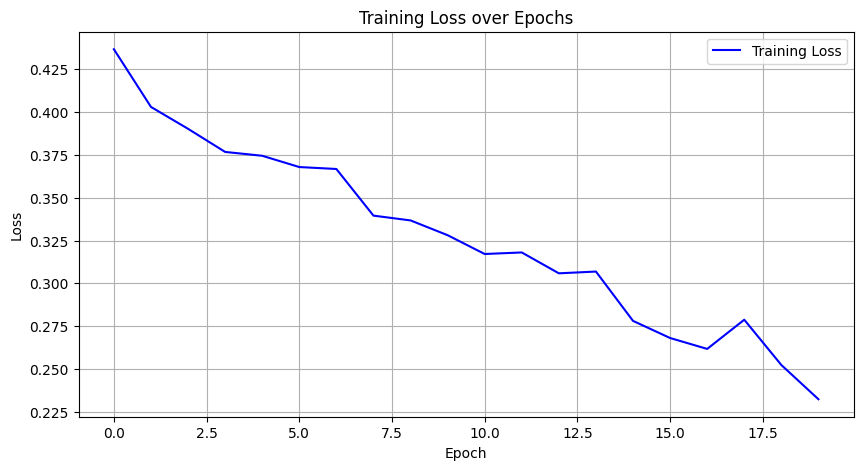

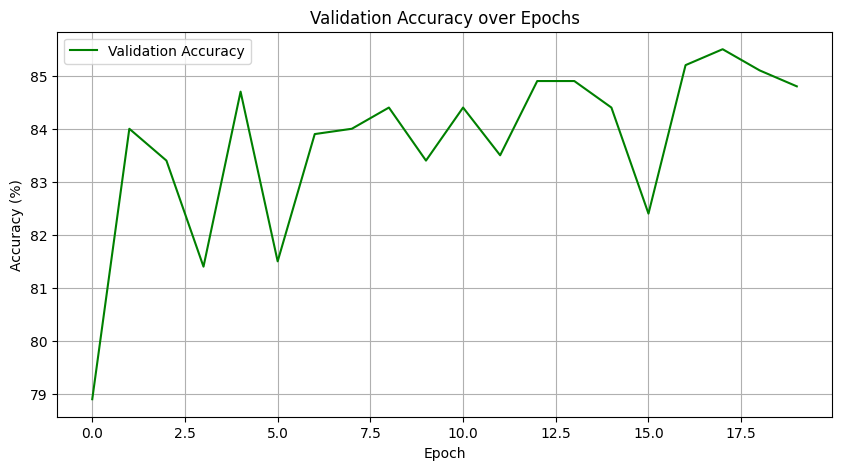

Model saved as 'model.pth'
Part 5 - Completed


In [17]:
# 1. Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss_plot.png') # Saving
plt.show()

# 2. Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png') # Saving
plt.show()

# 3. Save the Model
torch.save(model.state_dict(), "model.pth") # Saving
print("Model saved as 'model.pth'")
print("Part 5 - Completed")